## Volcanic hazards will be exacerbated by climate change–driven increase in heavy rainfall
### Jamie I. Farquharson1, Falk Amelung1
1 Rosenstiel School of Marine and Atmospheric Science, University of Miami, Miami, FL, USA

Corresponding author: james.farquharson@rsmas.miami.edu

### Import packages

In [1]:
'''
Import packages
'''
import datetime as dt
from netCDF4 import Dataset
import numpy as np
import numpy.ma as ma
import math

import fiona
import geopandas as gpd
from shapely.geometry import Point
from geopandas.geoseries import GeoSeries
from geopandas.geodataframe import GeoDataFrame

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap

import warnings
warnings.filterwarnings('ignore')

import matplotlib.font_manager as font_manager
from matplotlib import rcParams
plt.rcParams["font.family"] = 'sans-serif'

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Computer Modern Sans serif']
plt.rcParams["font.family"] = 'sans-serif'
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Palatino']
params = {'text.latex.preamble' : [r'\usepackage{amsmath}', r'\usepackage{amssymb}']}
plt.rcParams.update(params)

import random

from datetime import datetime, timedelta
import datetime as dt

import pandas as pd
import calendar

import matplotlib as matplotlib
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import seaborn as sns

from shapely import wkt
from geopandas.tools import sjoin
import geopandas

import scipy
from scipy.stats import gaussian_kde
from scipy import sparse

from decimal import Decimal
import os
import netCDF4
from matplotlib.colors import LinearSegmentedColormap

In [2]:
matplotlib.rcParams['text.usetex'] = True 
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage[cm]{sfmath}']
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'cm'
plt.rcParams["font.family"] = 'sans-serif'

In [3]:
filepath = '/Users/jamiefarquharson/Desktop/RSMAS/Eruption_ntbk'

In [4]:
'''
Function converts mm input to inches (for plotting figures the correct size).
'''

def mm2inch(*tupl):
    if isinstance(tupl[0], tuple):
        return tuple(k*0.0393701 for k in tupl[0])
    else:
        return tuple(k*0.0393701 for k in tupl)
    
'''
Function realigns subplots so that the upper right corners coincide
'''

def reposition(axis1, axis2):
    plt.draw()
    p1 = axis1.get_position()
    p2 = axis2.get_position()
    axis2.set_position([p1.x1-p2.width, p1.y1-p2.height, p2.width, p2.height])

'''
Function defines factorial of value x
'''
def fact(x):
    return Decimal(math.factorial(x))

'''
Function returns max and min of a list
'''
def minmax(x):
    x = sorted(x)
    return (x[0],x[-1])

In [31]:
'''
Re-orders multi-part names (for example, "Fournaise, Piton de la" becomes "Piton de la Fournaise")
'''
def string_rearranger(string):
    old_string = string
    if ', ' in old_string:
        new_string = old_string.rpartition(', ')[2] +' '+ old_string.rpartition(', ')[0]
    else:
        new_string = old_string
    return new_string

Load in perceptually uniform colourmaps from http://www.fabiocrameri.ch/colourmaps.php

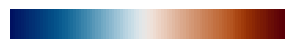

In [10]:
cm_data = np.loadtxt("climate_mods/ScientificColourMaps6/vik/vik.txt")
vik_map = LinearSegmentedColormap.from_list("vik", cm_data)
vik_map_r = LinearSegmentedColormap.from_list("vik", cm_data[::-1])
x = np.linspace(0, 100, 100)[None, :]
fig = plt.figure(1, mm2inch(90,10), dpi=100)
plt.imshow(x, aspect="auto",cmap=vik_map)
plt.axis("off")
plt.show()

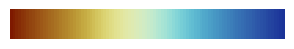

In [11]:

cm_data = np.loadtxt("climate_mods/ScientificColourMaps6/roma/roma.txt")
roma_map = LinearSegmentedColormap.from_list("roma", cm_data)
roma_map_r = LinearSegmentedColormap.from_list("roma", cm_data[::-1])
x = np.linspace(0, 10, 100)[None, :]
fig = plt.figure(1, mm2inch(90,10), dpi=100)
plt.imshow(x, aspect="auto",cmap=roma_map)
plt.axis("off")
plt.show()

In [12]:
'''Segment the "vik" colourmap'''

cmaplist = [vik_map_r(i) for i in range(vik_map_r.N)]
seg_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, vik_map_r.N)

# define the bins and normalize
bounds = np.linspace(-18, 18, 13)
norm = mpl.colors.BoundaryNorm(bounds, vik_map_r.N)


### Access volcano information and pre-process

In [13]:
'''
Accesses the most recent GVP volcanoes eruptions lists, saves them as csv files: "Holocene_volcanoes" and "Holocene_eruptions".
'''
!wget --no-check-certificate --output-document Holocene_eruptions.csv "https://webservices.volcano.si.edu/geoserver/GVP-VOTW/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=GVP_VOTW:Smithsonian_VOTW_Holocene_Eruptions&outputFormat=csv"
!wget --no-check-certificate --output-document Holocene_volcanoes.csv "https://webservices.volcano.si.edu/geoserver/GVP-VOTW/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=GVP_VOTW:Smithsonian_VOTW_Holocene_Volcanoes&outputFormat=csv"

'''
Read the downloaded csv file(s) into dataframe(s)
'''
volcano_list = pd.read_csv("Holocene_volcanoes.csv")
eruption_list = pd.read_csv("Holocene_eruptions.csv")

'''
Update volcano names to avoid duplicates
'''
temp_list = list(volcano_list.Volcano_Name)
duplicate_names = list(set([x for x in temp_list if temp_list.count(x) > 1]))
duplicate_numbers = []
for j in volcano_list.index:
    if volcano_list.Volcano_Name[j] in duplicate_names:
        volcano_list.Volcano_Name[j] = volcano_list.Volcano_Name[j]+' ' + str(volcano_list.Volcano_Number[j])
        duplicate_numbers.append(volcano_list.Volcano_Number[j])
len(set(duplicate_numbers))
for j in eruption_list.index:
    if eruption_list.Volcano_Number[j] in duplicate_numbers:
        eruption_list.Volcano_Name[j] = eruption_list.Volcano_Name[j]+' ' + str(eruption_list.Volcano_Number[j])

volcanoes = list(set(eruption_list.Volcano_Name)) ## {
print('{} volcano entries found, with a total of {} eruptions.\n{} distinct volcanoes identified.\n{} duplicate names:\n{}'.format(
    len(volcano_list),len(eruption_list),len(volcanoes), len(duplicate_names), duplicate_names))                           

--2021-01-22 09:43:06--  https://webservices.volcano.si.edu/geoserver/GVP-VOTW/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=GVP_VOTW:Smithsonian_VOTW_Holocene_Eruptions&outputFormat=csv
Resolving webservices.volcano.si.edu (webservices.volcano.si.edu)... 160.111.244.27
Connecting to webservices.volcano.si.edu (webservices.volcano.si.edu)|160.111.244.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘Holocene_eruptions.csv’

Holocene_eruptions.     [          <=>       ]   2.01M  1015KB/s    in 2.0s    

2021-01-22 09:43:10 (1015 KB/s) - ‘Holocene_eruptions.csv’ saved [2112137]

--2021-01-22 09:43:10--  https://webservices.volcano.si.edu/geoserver/GVP-VOTW/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=GVP_VOTW:Smithsonian_VOTW_Holocene_Volcanoes&outputFormat=csv
Resolving webservices.volcano.si.edu (webservices.volcano.si.edu)... 160.111.244.27
Connecting to webservices.volcano.si.edu (webservices.volc

In [14]:
'''
Extracts latitude and longitude data for each volcano in 'volcano_list' [formatted in the dataframe as 'POINT (x.xx x.xxx)'] (WKT format?).
Updates dataframe with extracted coordinates.
'''

lons = []
lats = []
for j,k in enumerate(volcano_list.GeoLocation):
    lons.append(float(k[7:-1].split()[0])) # Extracts longitude as string, converts to float
    lats.append(float(k[7:-1].split()[1])) # Extracts latitude as string, converts to float
volcano_list['lats'] = lats # Adds latitudes to original dataframe
volcano_list['lons'] = lons # Advods longitudes to original dataframe

import fnmatch
lst = list(set(volcano_list.Primary_Volcano_Type))
filtered = fnmatch.filter(lst, 'Sub*')
volcano_list = volcano_list.loc[~volcano_list["Primary_Volcano_Type"].isin(filtered)]
print('Done\nand')

'''
Coordinates ready for plotting
'''
locations = volcano_list[['lats', 'lons']]
locations["name"] = volcano_list.Volcano_Name
locations["number"] = volcano_list.Volcano_Number
locationlist = locations.values.tolist
print('Done')

Done
and
Done


In [15]:
'''
Creates dataframe with eruption information for all active volcanoes
'''
volcano_countries = volcano_list.set_index('Country')
all_active_volcanoes = pd.merge(eruption_list,volcano_countries, how = 'inner', on = ['Volcano_Name'])

In [16]:
'''
Dataframe contains Name, lat, and lon of each eruptive volcano
'''

all_volcano_set_name = []
all_volcano_set_lat = []
all_volcano_set_lon = []
all_volcano_set_point = []

for j, k in enumerate(all_active_volcanoes.Volcano_Name):
    if k not in all_volcano_set_name:
        all_volcano_set_name.append(k)
        all_volcano_set_lat.append(all_active_volcanoes.lats[j])
        all_volcano_set_lon.append(all_active_volcanoes.lons[j])
        all_volcano_set_point.append(all_active_volcanoes.GeoLocation_y[j])
        

all_volcano_set = pd.DataFrame({'Name' :all_volcano_set_name,'lat' : all_volcano_set_lat, 'lon' : all_volcano_set_lon, 'point' : all_volcano_set_point})
all_volcano_set.set_index('Name', inplace = True)
print('{} discrete volcanoes in unfiltered dataset'.format(len(all_volcano_set)))

830 discrete volcanoes in unfiltered dataset


In [26]:
'''
Dataframe contains Name, lat, and lon of each eruptive volcano
'''

volcano_set_name = []
volcano_set_lat = []
volcano_set_lon = []

for j, k in enumerate(all_active_volcanoes.Volcano_Name):
    if k not in volcano_set_name:
        volcano_set_name.append(k)
        volcano_set_lat.append(all_active_volcanoes.lats[j])
        volcano_set_lon.append(all_active_volcanoes.lons[j])

volcano_set = pd.DataFrame({'Name' :volcano_set_name,'lat' : volcano_set_lat, 'lon' : volcano_set_lon})
volcano_set.set_index('Name', inplace = True)

### Functions for reading and processing climate data

In [17]:
''' Models used '''
fileNameCodes = [['NorESM1-M',
  'CSIRO-Mk3-6-0',
  'MRI-CGCM3',
  'ACCESS1-3',
  'inmcm4',
  'MIROC5',
  'IPSL-CM5A-MR',
  'CanESM2',
  'CNRM-CM5']]

In [19]:
def list_of_models(parameter = "pr", modelName =""):
    import glob as glob
    models = [mod for mod in glob.glob("climate_mods/{}*".format(parameter))]
    modelList = []
    for modelString in models:
        if modelName in modelString:
            modelList.append(modelString)
    return sorted(modelList)

In [20]:
'''https://stackoverflow.com/a/3431835/11191589''' ## Need to include hash list
import hashlib
def hash_bytestr_iter(bytesiter, hasher, ashexstr=False):
    for block in bytesiter:
        hasher.update(block)
    return hasher.hexdigest() if ashexstr else hasher.digest()

def file_as_blockiter(afile, blocksize=65536):
    with afile:
        block = afile.read(blocksize)
        while len(block) > 0:
            yield block
            block = afile.read(blocksize)

def checksum(parameter="pr", modelName=""):
    fnamelst = list_of_models(parameter=parameter, modelName=modelName)
    return [(fname, hash_bytestr_iter(file_as_blockiter(open(fname, 'rb')), hashlib.md5()))
    for fname in fnamelst]

In [21]:
for i in range(9):
    checkSum = checksum(parameter="pr", modelName=fileNameCodes[0][i])
    print(checkSum[0][1])
# checkdict

b'\x8b)\xb5\xaeh<\x1dg\xc9C\x98\x06\xbf\xde\x9c\xeb'
b'\x87\xf2\x16\xabU\xa1\xab\x88!BQt\xcd\xcc\xd2\xbd'
b'.\x99y\x97\xe2\xa1\x9c\xf5\xe1B\xdf\xbd\x1b\xbb\xe3l'
b'\xe4\xb3\x15G\xa3m\x10\x8a\x08\xecv\xa9\x80\x8a\xd5K'
b'\xbb\xb0\x19r\x15\x9dx/O\xe7\xc7\xf2\xff\xd2\xda\xca'
b'\xdd[\x8e\x8d\x93\xf4-~3\xca3)\x88x\xb6y'
b"\xe3\x1c\xabI\xf6=9I\x89'4I\xaa\x1coe"
b'{\x05\x0b&\xb2\xd6\x9d:\x01\xf3\xd2\x8eu\xb6"5'
b'*\xc0ZM\xe4\x83\x18\x9b\xb1+\x05\x02\xb4\x01\x0b\x8a'


In [22]:
def model_info(parameter="pr", modelName="", checkSum=False):
    import netCDF4
    import hashlib
    try:
        modelFile = netCDF4.MFDataset(list_of_models(parameter=parameter, modelName=modelName))
        if checkSum == False:
            print('model: {}; var: {}; (time,lat,lon) : {}; (la,lo) : {:.1f} {:.1f}'.format(
        modelFile.__dict__['model_id'],
        modelFile.variables[parameter].long_name,
        modelFile.variables[parameter].shape,
        modelFile.variables['lat'][0],
        modelFile.variables['lon'][0]
    ))
            modelFile.close()
        else:
            checksum = checksum(parameter=parameter, modelName=modelName)
            print(checksum)

# print(file_hash.digest())
# print(file_hash.hexdigest())  # to get a printable str instead of bytes
    except:
        print("Error reading {}".format(modelName)) ## checksum heree

In [23]:
def model_lalo(parameter="pr", modelName=""):
    import netCDF4
    try:
        modelFile = netCDF4.MFDataset(list_of_models(parameter=parameter, modelName=modelName))
#         print("ok")
        return modelFile.variables["lat"][:], modelFile.variables["lon"][:]
    except:
        print("Error reading {}".format(modelName))

In [24]:
def volcano_ij(volcano, lats, lons, verbose = False):
    volcano = volcano
    lon_vals = lons
    lat_vals = lats
    try:
        name_volc = volcano
        lat_volc = volcano_set.loc[[name_volc]].lat.values[0]
        lon_volc = volcano_set.loc[[name_volc]].lon.values[0]+180

        '''
        Data are not infinite, so these lambda functions determine the latitude and longitute in the NCDF4 file(s) that
        are *closest* to the precise coordinates of a given volcano. Volcano coordinates are defined above (lat_volc, lon_volc),
        and typically correspond to the summit or centre of the caldera region.
        '''
        j_volc = min(lon_vals, key=lambda x:abs(x-lon_volc))
        i_volc = min(lat_vals, key=lambda x:abs(x-lat_volc))
        if verbose == True:
            print("({:.1f},{:.1f}) --> ({:.1f},{:.1f})".format(
            lat_volc,lon_volc, i_volc, j_volc))
        return i_volc, j_volc
    except:
        print("Problem with {}".format(string_rearranger(volcano)))
  

#### Sanity check 

In [28]:
''' Convert geolocation to model-specific (i,j) coordinates''' 
lat, lon = model_lalo(parameter="pr", modelName=fileNameCodes[0][1])
volcano_ij(volcano = "St. Helens", lats = lat, lons = lon)

(45.698692321777344, 58.125)

In [29]:
def global_mean_temp(modelName, method = "max", verbose = False):
    ''' "how" can be either "max" or "mean" '''
    import netCDF4
    import pandas as pd
    try:
        modelFile = netCDF4.MFDataset(list_of_models(parameter="ta", modelName=modelName))
#         print("imported")
        startString = modelFile.variables["time"].units.split()[2] # Days since XXX date
        start = datetime.strptime(startString, "%Y-%m-%d")
        time = [start+timedelta(int(x)) for x in modelFile.variables["time"][:]]
        model_gmT = []
#         print("ok")
        for x in range(modelFile.variables["ta"].shape[0]):
            model_gmT.append(np.nanmean(modelFile.variables["ta"][x][0]))
        gmT_df = pd.DataFrame(
    {'ix':time,'date':time, ##
     'temp': model_gmT
    })
        gmT_df=gmT_df.set_index('ix')
        gmT_df.index = pd.to_datetime(gmT_df.index)
        gmT = gmT_df.resample("Y", how=method)
#         gmT_av = gmT_df.resample("Y", how='mean')

        modelFile.close()
        if verbose == True:
            print("{} succesfully processed".format(modelName))
        return gmT, gmT_df
    except:
        print("Error reading {}".format(modelName))

def heavy_rainfall(i_volc, j_volc, modelName="", method = "max", verbose = False):
    ''' "how" can be either "max" or "mean" '''
    import netCDF4
    import pandas as pd
    try:
        modelFile = netCDF4.MFDataset(list_of_models(parameter="pr", modelName=modelName))
        startString = modelFile.variables["time"].units.split()[2] # Days since XXX date
        start = datetime.strptime(startString, "%Y-%m-%d")
        time = [start+timedelta(int(x)) for x in modelFile.variables["time"][:]]
        rx_volc = []
        lat_vals = modelFile.variables["lat"][:]
        lon_vals = modelFile.variables["lon"][:]
#         print("ok to here1")
        i = int(np.where(lat_vals==i_volc)[0])
#         print("ok to here2")
        j = int(np.where(lon_vals==j_volc)[0])
#         print("ok to here3")
        prcp = list(modelFile.variables["pr"][:,i,j])
        temp_df = pd.DataFrame(
    {'ix':time,'date':time, ##
     'rainfall': prcp
    })
        temp_df=temp_df.set_index('ix')
        temp_df.index = pd.to_datetime(temp_df.index)
        RX1 = temp_df.resample("Y", how=method)
#         RX1_av = temp_df.resample("Y", how='mean')
#         m, c, r, p, s = linregress(gmT,temp_df.rainfall)  ### call in gmT?
#         rx_volc.append((m*2100+c)/(m*2006+c))

        modelFile.close()
        if verbose == True:
            print("{} succesfully processed".format(modelName))
        return temp_df, RX1
    except:
        print("Error reading {}".format(modelName))
        
